In [ ]:
import random
import numpy as np
from copy import deepcopy
from sklearn.linear_model import LinearRegression

class EVOLUTIONARY_ANFIS:
    def __init__(self,functions,generations,offsprings,mutationRate,learningRate,chance,ruleComb):
        self.functions = functions
        self.generations = generations
        self.offsprings = offsprings
        self.mutationRate = mutationRate
        self.learningRate = learningRate
        self.chance = chance #50 percent chance of changing std.
        self.ruleComb = ruleComb
        self._noParam = 2

    def gaussian(self,x, mu, sig):
        return np.exp((-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))

    def initialize(self,X):
        functions = self.functions
        noParam = self._noParam
        ruleComb = self.ruleComb
        inputs = np.zeros((X.shape[1],X.shape[0],functions))
        Ant = np.zeros((noParam,X.shape[1],X.shape[0],functions))
        L1 = np.zeros((X.shape[1],X.shape[0],functions))
        if ruleComb == "simple":
            L2 = np.zeros((X.shape[0],functions))
        elif ruleComb == "complete":
            rules = X.shape[1]**functions
            L2 = np.zeros((X.shape[0],rules))
        return inputs, Ant, L1, L2

    def mutation(self,arr):
        mutationRate = self.mutationRate
        learningRate = self.learningRate
        chance = self.chance
        temp = np.asarray(arr)   # Cast to numpy array
        mean = temp[0]
        meanShape = mean.shape
        std = temp[1]
        stdShape = std.shape
        mean = mean.flatten()    # Flatten to 1D
        std = std.flatten()    # Flatten to 1D
        num = int(mutationRate*mean.size) # number of elements to get
        if random.uniform(0,1)>chance:
            inds = np.random.choice(mean.size, size=num)   # Get random indices
            mean[inds] -= np.random.uniform(0,1,size=num)*learningRate        # Fill with something
            mean = mean.reshape(meanShape)                     # Restore original shape
            std = std.reshape(stdShape)
        else:
            inds = np.random.choice(std.size, size=num)   # Get random indices
            std[inds] -= np.random.uniform(0,1,size=num)*learningRate        # Fill with something
            std = std.reshape(stdShape)                     # Restore original shape
            std = np.where(std==0, 0.0001, std) #standard deviation cannot be zero
            #temp = np.where(temp<=0, 0.0001, temp)
            #temp = np.where(temp>=1, 0.9999, temp)

            mean = mean.reshape(meanShape)
        temp[0] = mean
        temp[1] = std
        return temp

    def init_population(self,X):
        noParam = self._noParam
        functions = self.functions
        offsprings = self.offsprings
        bestParam = np.random.rand(noParam,X.shape[1],functions)
        parentParam = deepcopy(bestParam)
        popParam = []
        for i in range(offsprings):
            popParam.append(self.mutation(parentParam))
        return popParam

    def init_model(self,model=LinearRegression()):
        models = []
        for i in range(self.functions):
                models.append(model)
        return models

    def forwardPass(self,param,X,inputs,Ant,L1,L2,functions):
        noParam = self._noParam

        for i in range(X.shape[1]):   #input variables
            inputs[i] = np.repeat(X[:,i].reshape(-1,1),functions,axis=1)

        for ii in range(noParam):   #Anticedent parameters
            for i in range(X.shape[1]):
                Ant[ii] = np.repeat(param[ii][i,:].reshape(1,-1),X.shape[0],axis=0)

        for i in range(X.shape[1]):  #Membership values using Gaussian membership function
            L1[i,:,:] = self.gaussian(x=inputs[i],mu=Ant[0][i],sig=Ant[1][i])

        for j in range(functions):      #rule
            for i in range(1,X.shape[1]):
                L2[:,j] = (L1[i-1,:,j]*L1[i,:,j])#+(L1[i-1,:,j]+L1[i,:,j])

        summ = np.sum(L2,axis=1).reshape(-1,1) #Weights normalization
        summation = np.repeat(summ,functions,axis=1)
        L3 = L2/summation
        L3 = np.round(L3,5)
        #Errorcheck = np.sum(L3,axis=1)

        consequent = X
        L4 = np.zeros((functions,X.shape[0],X.shape[1]))
        for i in range (functions):
            L4[i] = consequent
            L4[i] = L4[i]*L3[:,i].reshape(-1,1)
        return L1,L2,L3,L4

    def linear_fit(self,L3,L4,X,y,functions,models):
        pred_train = np.zeros((X.shape[0],functions))
        for i in range(functions):
            models[i].fit(L4[i],y)
            predTemp = models[i].predict(L4[i])
            pred_train[:,i] = predTemp[:,0]
        pred_train = pred_train*L3 #consequent function output * normalized weights
        pred_train = np.sum(pred_train,axis=1)
        return pred_train, models

    def linear_predict(self,L3,L4,X,functions,Trained_models):
        pred_test = np.zeros((X.shape[0],functions))
        for i in range(functions):
            predTemp = Trained_models[i].predict(L4[i]).reshape(-1,1)
            pred_test[:,i] = predTemp[:,0]
        pred_test = pred_test*L3 #consequent function output * normalized weights
        pred_test = np.sum(pred_test,axis=1)
        return pred_test

    @staticmethod
    def rmse(true, pred):
      loss = np.sqrt(np.mean((true - pred)**2))
      return loss

    def fit(self,X_train,y_train,X_test=None,y_test=None,optimize_test_data=False):
        generations = self.generations
        offsprings = self.offsprings
        functions = self.functions
        popParam = self.init_population(X_train)
        inputsTrain,AntTrain,L1Train,L2Train = self.initialize(X_train)
        if optimize_test_data:
            inputsTest,AntTest,L1Test,L2Test = self.initialize(X_test)
        models = self.init_model()
        bestParam = popParam[0]
        for gen in range(generations):
            parentParam = deepcopy(bestParam)
            popParam[0] = deepcopy(bestParam)
            for ii in range(1,offsprings):
                mut = self.mutation(parentParam)
                popParam[ii] = deepcopy(mut)

            PopulationError = []
            bestModelLst = []
            for i in range(len(popParam)):
                L1,L2,L3,L4 = self.forwardPass(popParam[i],X_train,inputsTrain,AntTrain,L1Train,L2Train,functions)
                pred_train, Trained_models = self.linear_fit(L3,L4,X_train,y_train,functions,models)
                mse_train = self.rmse(y_train,pred_train)

                if optimize_test_data:
                    L1,L2,L3,L4 = self.forwardPass(popParam[i],X_test,inputsTest,AntTest,L1Test,L2Test,functions)
                    pred_test = self.linear_predict(L3,L4,X_test,functions,Trained_models)
                    mse_test = self.rmse(y_test,pred_test)

                    PopulationError.append((mse_train+mse_test)/2)
                    bestModelLst.append(Trained_models)
                else:
                    PopulationError.append(mse_train)
                    bestModelLst.append(Trained_models)

            bestParamIndex = np.argmin(PopulationError)
            bestParam = deepcopy(popParam[bestParamIndex])
            bestModel = bestModelLst[bestParamIndex]
            print(gen,"RMSE is: ",PopulationError[bestParamIndex])
        return bestParam, bestModel

    def predict(self,X,bestParam,bestModel):
        functions = self.functions
        inputs,Ant,L1,L2 = self.initialize(X)
        L1,L2,L3,L4 = self.forwardPass(bestParam,X,inputs,Ant,L1,L2,functions)
        pred = self.linear_predict(L3,L4,X,functions,bestModel)
        return pred

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[[0.20833333 0.26785714 0.7        ... 0.98311688 0.14285714 0.16666667]
 [0.95833333 0.74285714 0.52857143 ... 0.59220779 0.14285714 0.        ]
 [0.68055556 0.36428571 0.92857143 ... 0.08051948 0.         0.66666667]
 ...
 [0.04166667 0.08214286 0.07142857 ... 0.61688312 0.85714286 0.        ]
 [0.5        0.08928571 0.48571429 ... 0.28311688 0.         0.66666667]
 [0.09722222 1.         0.67142857 ... 0.51298701 0.57142857 0.66666667]]
[[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 

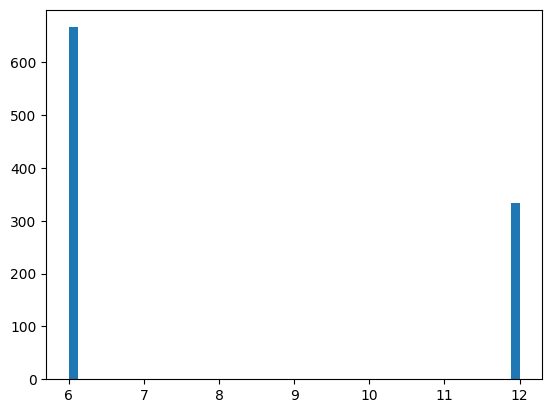

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler


from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/Project_IC_Heart/dataset_1000.csv')
test = pd.read_csv('/content/drive/MyDrive/Project_IC_Heart/dataset_1000.csv')
data.head()

#from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your pandas DataFrame

# Instantiate the StandardScaler
#scaler = StandardScaler()

# Standardize the DataFrame
#normalized_df = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Print the new standardized dataset
#print(normalized_df)
#Data = normalized_df.loc[:,['age','cholesterol','heart_rate', 'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol', 'exercise', 'previous_problems', 'medication', 'stress_level', 'sedentary', 'bmi', 'trigl', 'physical_activity', 'sleep_hour', 'risk']]
#test = normalized_df.loc[:,['age','cholesterol','heart_rate', 'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol', 'exercise', 'previous_problems', 'medication', 'stress_level', 'sedentary', 'bmi', 'trigl', 'physical_activity', 'sleep_hour', 'risk']]

Data = data.loc[:,['age','cholesterol','heart_rate', 'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol', 'exercise', 'previous_problems', 'medication', 'stress_level', 'sedentary', 'bmi', 'trigl', 'physical_activity', 'sleep_hour', 'risk']]
test = test.loc[:,['age','cholesterol','heart_rate', 'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol', 'exercise', 'previous_problems', 'medication', 'stress_level', 'sedentary', 'bmi', 'trigl', 'physical_activity', 'sleep_hour', 'risk']]

#Data = data.loc[:,['FC','VM','Ash','Moisture','Cal V']]

# digitizing continuous variable
aa = Data['risk']
minima = aa.min()
maxima = aa.max()
bins = np.linspace(minima-1,maxima+1, 18)
binned = np.digitize(aa, bins)
plt.hist(binned, bins=50)
data_train, data_test = train_test_split(Data, test_size=0.2,
                                          random_state=101,stratify=binned)

X_train = data_train.drop("risk",axis=1).values
y_train = data_train["risk"].copy().values
X_test = data_test.drop("risk",axis=1).values
y_test = data_test["risk"].copy().values
X_val = test.drop("risk",axis=1).values
y_val = test["risk"].copy().values

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_x.fit(X_train)
X_train = scaler_x.transform(X_train)
X_test = scaler_x.transform(X_test)
#X_val = scaler_x.transform(X_val)
scaler_y.fit(y_train.reshape(-1,1))
y_train = scaler_y.transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))
#y_val = scaler_y.transform(y_val.reshape(-1,1))

print(X_train)
print(y_train)


In [ ]:
#from ANFIS import EVOLUTIONARY_ANFIS

E_Anfis = EVOLUTIONARY_ANFIS(functions=3,generations=200,offsprings=10,
                             mutationRate=0.0002,learningRate=0.001,chance=0.7,ruleComb="simple")

bestParam, bestModel = E_Anfis.fit(X_train,y_train,optimize_test_data=False)

bestParam, bestModel = E_Anfis.fit(X_train,y_train,X_test,y_test,optimize_test_data=True)



0 RMSE is:  0.47668590816043294
1 RMSE is:  0.47668590816043294
2 RMSE is:  0.47668590816043294
3 RMSE is:  0.47668590816043294
4 RMSE is:  0.47668590816043294
5 RMSE is:  0.47668590816043294
6 RMSE is:  0.47668590816043294
7 RMSE is:  0.47668590816043294
8 RMSE is:  0.47668590816043294
9 RMSE is:  0.47668590816043294
10 RMSE is:  0.47668590816043294
11 RMSE is:  0.47668590816043294
12 RMSE is:  0.47668590816043294
13 RMSE is:  0.47668590816043294
14 RMSE is:  0.47668590816043294
15 RMSE is:  0.47668590816043294
16 RMSE is:  0.47668590816043294
17 RMSE is:  0.47668590816043294
18 RMSE is:  0.47668590816043294
19 RMSE is:  0.47668590816043294
20 RMSE is:  0.47668590816043294
21 RMSE is:  0.47668590816043294
22 RMSE is:  0.47668590816043294
23 RMSE is:  0.47668590816043294
24 RMSE is:  0.47668590816043294
25 RMSE is:  0.47668590816043294
26 RMSE is:  0.47668590816043294
27 RMSE is:  0.47668590816043294
28 RMSE is:  0.47668590816043294
29 RMSE is:  0.47668590816043294
30 RMSE is:  0.47668

In [ ]:
dataset_test2 = pd.read_csv('/content/drive/MyDrive/Project_IC_Heart/dataset_1000.csv')

[[ 0.31597787]
 [41.03246781]
 [30.07132689]
 [35.51499142]
 [64.37887454]
 [37.33235068]
 [17.32683969]
 [47.64752598]
 [26.64902245]
 [52.34712419]
 [ 7.23352447]
 [28.56363406]
 [29.38136451]
 [35.72428277]
 [25.2623326 ]
 [38.24324859]
 [38.63879248]
 [35.76290444]
 [35.60873619]
 [28.99402017]
 [36.01160058]
 [45.33609265]
 [23.55473355]
 [35.46847927]
 [35.07079659]
 [62.81789404]
 [14.3447685 ]
 [21.76615483]
 [46.59364112]
 [54.56105895]
 [49.25036428]
 [22.75104138]
 [53.3785213 ]
 [ 6.67745509]
 [37.98363441]
 [33.95974872]
 [25.20985453]
 [53.59576214]
 [20.66458629]
 [31.05030165]
 [50.59357514]
 [59.80792399]
 [29.85075911]
 [40.74439858]
 [53.28797983]
 [35.01905537]
 [16.59799918]
 [64.89511242]
 [40.5833066 ]
 [19.74841097]
 [61.90366053]
 [47.82745005]
 [42.26237443]
 [41.15238433]
 [38.64149282]
 [42.03050346]
 [75.59847499]
 [82.35857604]
 [27.66570921]
 [24.47924332]
 [39.11389698]
 [-4.71808918]
 [ 3.30006966]
 [25.06224   ]
 [67.46499989]
 [50.31306898]
 [43.33376

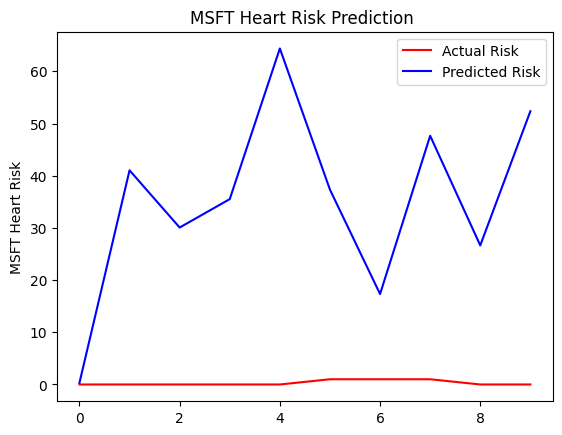

In [ ]:
pred_test = E_Anfis.predict(X_test,bestParam,bestModel)
#print(pred_test)
pred_test = sc.inverse_transform(pred_test.reshape(-1,1))
print(pred_test)
# plot loss during training
#pyplot.subplot(211)
#pyplot.title('PRED')
#pyplot.plot(pred_test, label='ANFIS')
#pyplot.legend()


plt.plot(dataset_test['risk'].values[:10], color = 'red', label = 'Actual Risk')
plt.plot(pred_test[0:10], color = 'blue', label = 'Predicted Risk')
plt.title('MSFT Heart Risk Prediction ')
#plt.xlabel('Time')
plt.ylabel('MSFT Heart Risk')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from google.colab import drive
drive.mount('/content/drive')
dataset_train = pd.read_csv('/content/drive/MyDrive/Project_IC_Heart/dataset_1000.csv')
training_set = dataset_train.iloc[:, 1:2].values
#print(training_set)
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
#print(training_set_scaled)
X_train = []
y_train = []

#training data set 10 to 1 scalled
#print(training_set_scaled[10-10:10, 0])
#print(training_set_scaled[0, 0])

for i in range(14, 252):
    X_train.append(training_set_scaled[i-14:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#print(X_train)
#print(y_train)
display(dataset_train)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,risk,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol,exercise,previous_problems,medication,stress_level,sedentary,bmi,trigl,physical_activity,sleep_hour
0,0,67,208,72,0,0,1,0,0,4.168,0,0,9,6.615001,31.251233,286,0,6
1,0,21,389,98,1,1,1,1,1,1.813,1,0,1,4.963459,27.194973,235,1,7
2,0,21,324,72,1,0,0,0,0,2.078,1,1,9,9.463426,28.176571,587,4,4
3,0,84,383,73,1,1,1,0,1,9.828,1,0,9,7.648981,36.464704,378,3,4
4,0,66,318,93,1,1,1,1,0,5.804,1,0,6,1.514821,21.809144,231,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,79,366,52,0,1,1,1,0,16.491,1,0,10,10.685000,27.287000,197,2,5
996,1,43,164,81,1,1,1,0,0,1.348,1,0,3,7.388000,19.068000,133,7,6
997,0,31,127,88,1,1,0,1,0,7.569,0,1,7,2.408000,36.475000,218,1,10
998,0,70,128,54,0,0,1,0,1,15.870,0,0,8,0.613000,23.112000,394,2,8


In [ ]:
regressor = Sequential()
#layer 1 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
#Layer 2 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
#Layer 3 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
#Layer 4 50 neurons
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
#adam optimizer has better results then Adamax, RMSprop
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics = ['MAPE'])
reg = regressor.fit(X_train, y_train, epochs = 150, batch_size = 2)


Epoch 1/150
119/119 [==============================] - 9s 25ms/step - loss: 0.1079 - MAPE: 4273123.5000
Epoch 2/150
119/119 [==============================] - 2s 19ms/step - loss: 0.0995 - MAPE: 3784206.0000
Epoch 3/150
119/119 [==============================] - 2s 16ms/step - loss: 0.0935 - MAPE: 4628325.0000
Epoch 4/150
119/119 [==============================] - 2s 16ms/step - loss: 0.0985 - MAPE: 3900369.2500
Epoch 5/150
119/119 [==============================] - 2s 16ms/step - loss: 0.0959 - MAPE: 3740067.0000
Epoch 6/150
119/119 [==============================] - 2s 15ms/step - loss: 0.0964 - MAPE: 4228023.5000
Epoch 7/150
119/119 [==============================] - 2s 19ms/step - loss: 0.0919 - MAPE: 4185956.2500
Epoch 8/150
119/119 [==============================] - 3s 25ms/step - loss: 0.0921 - MAPE: 4291380.0000
Epoch 9/150
119/119 [==============================] - 2s 16ms/step - loss: 0.0933 - MAPE: 5293579.0000
Epoch 10/150
119/119 [==============================] - 2s 16ms/

Train: 4122702.000, Test: 4122702.000


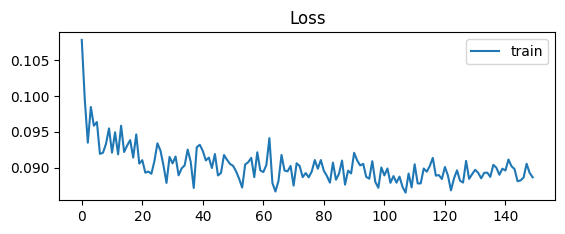

In [ ]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
_, train_mse = regressor.evaluate(X_train, y_train, verbose=0)
_, test_mse = regressor.evaluate(X_train, y_train, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(reg.history['loss'], label='train')
pyplot.legend()
# plot mse during training